# Wavefront sensing in hcipy

In hcipy, wavefront sensing and reconstruction is achieved by a combination of two separate components - a wavefront sensor and a wavefront estimator. The wavefront sensor (WFS) consists of the optics and the wavefront estimator (WFE) performs the mathematical calculations required to reconstruct a wavefront from the optical system measurements. In this example we will use a Shack-Hartmann wavefront sensor and estimator. We will simulate phase-screens using the atmosphere library from hcipy.

First, we import hcipy and supporting libraries.

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We create an aperture and a pupil grid on which the phasescreens will be imposed, a focal plane where the image is formed, and a propagator to take the wavefront from the pupil plane to the focal plane.

In [2]:
wavelength = 500e-9
N = 256
D = 0.01
pupil_grid = make_pupil_grid(N, D)
focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D)

We will create two wavefronts to use in this example - a flat wavefront for reference, and a wavefront which we will sense and attempt to reconstruct with a SH-WFS.

/home/vikram/miniconda3/envs/hcipy/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


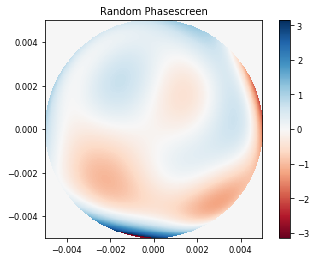

In [3]:
# Reference flat wavefront
wf = Wavefront(aperture(pupil_grid),wavelength)
wf.total_power = 1

# Wavefront to be reconstructed
np.random.seed(42)
num_modes = 25
zernike_modes = make_zernike_basis(num_modes, D, pupil_grid, 2, False)
coeffs = np.random.uniform(low=-0.2, high=0.2, size=25)
wf_phase = np.dot(zernike_modes.transformation_matrix, coeffs)
e_field = Field(np.exp(1j * wf_phase), pupil_grid)
wf2sense = Wavefront(e_field * aperture(pupil_grid), wavelength)
wf2sense.total_power=1

imshow_field(wf2sense.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu'); plt.title("Random Phasescreen"); plt.colorbar()

## Shack Hartmann wavefront sensor

A Shack Hartmann Wavefront Sensor (SH-WFS) consists of a microlens array and a detector. Local gradients in the wavefront result in shifts in the centroids of the images created by the corresponding individual lenslets. We can then use these centroids to estimate the local gradients, and use this information to reconstruct the complete wavefront.

We start by creating the SH-WFS using a microlens array optic.

In [4]:
F_mla = 40. / 0.3
N_mla = 20 # number of subapertures across the lenslet array

shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid, F_mla, N_mla, D)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

Next, we need a deformable mirror with which to calibrate our wavefront sensor.

Our deformable mirror in this example is modeled as a Zernike freeform surface where each mode is a Zernike polynomial.

In [5]:
# DM slightly larger than the pupil plane for better edge performance
actuator_grid = make_pupil_grid(5, D*1.1)
sigma = D/5.
gaussian_basis = make_gaussian_pokes(pupil_grid, actuator_grid, sigma)
dm = DeformableMirror(gaussian_basis)
num_modes = len(dm.influence_functions)
dm.actuators = np.zeros(num_modes)

The calibration process is as follows: we "poke" each mode of the DM with an equal positive and a negative amplitude successively, measure the shifts in the centroids of the microlens array images, and use these measurements to construct an interaction matrix.

In [6]:
# First set the amplitudes of all DM modes to zero, and measure the reference position of the centroids
img = shwfs.forward(wf).power
ref = shwfse.estimate([img]).ravel()
num_measurements = ref.shape[0]

# Now push on each mode individually and record the centroid shifts
amp = 1e-6
Intmat = []

for dm_mode in np.arange(num_modes):

    print("Now calibrating actuator {}/{}".format(dm_mode+1, num_modes))
    
    # Reset the list of slopes (average centroid shifts for each lenslet image)
    total_slopes = np.zeros((num_measurements,))

    # Push an actuator with a positive and negative amplitude
    for push in np.array([-amp, amp]):

        act_levels = np.zeros(num_modes)
        act_levels[dm_mode] = push

        dm.actuators = act_levels
        dm_wf = dm.forward(wf)
        sh_wf = shwfs.forward(dm_wf)
        sh_img = sh_wf.power # Save the image created at the wavefront sensor - to see the effect of poking modes
        imsave_field("WFS_calibrate_" + str(dm_mode+1).zfill(2), sh_img)
        
        # Use the estimator to calculate the shifts in the centroids
        lenslet_centers = shwfse.estimate([sh_img])
        total_slopes += (lenslet_centers.ravel()- ref)/(2*push)
    Intmat.append(total_slopes)

dm.actuators = np.zeros(num_modes)

Intmat = ModeBasis(Intmat)

Now calibrating actuator 1/25
Now calibrating actuator 2/25
Now calibrating actuator 3/25
Now calibrating actuator 4/25
Now calibrating actuator 5/25
Now calibrating actuator 6/25
Now calibrating actuator 7/25
Now calibrating actuator 8/25
Now calibrating actuator 9/25
Now calibrating actuator 10/25
Now calibrating actuator 11/25
Now calibrating actuator 12/25
Now calibrating actuator 13/25
Now calibrating actuator 14/25
Now calibrating actuator 15/25
Now calibrating actuator 16/25
Now calibrating actuator 17/25
Now calibrating actuator 18/25
Now calibrating actuator 19/25
Now calibrating actuator 20/25
Now calibrating actuator 21/25
Now calibrating actuator 22/25
Now calibrating actuator 23/25
Now calibrating actuator 24/25
Now calibrating actuator 25/25


To reconstruct a wavefront, we need the control matrix which is obtained by inverting the interaction matrix. We use the singular value decomposition functionality offered to us by hcipy to obtain a pseudo-inverse of this matrix, cut off the singular values that are below a threshold.

In [7]:
control_mat = inverse_truncated(Intmat.transformation_matrix, rcond=1e-2)

With this information, we can reconstruct a wavefront using the SH-WFS centroid measurements it produces, on the modal basis of the DM. Let's see how well we can reconstruct the atmospheric turbulence phase screen from earlier.

/home/vikram/miniconda3/envs/hcipy/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


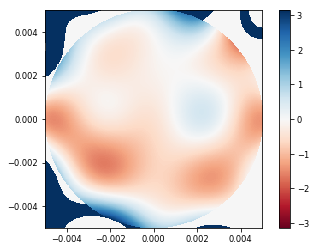

In [8]:
# Reset the DM modes to zero amplitude
dm.actuators = np.zeros(num_modes)

# Propagate the wavefront through the WFS optics
dm_wf = dm.forward(wf2sense)
sh_wf = shwfs.forward(dm_wf)
sh_img = sh_wf.power

# Estimate
meas_vec = shwfse.estimate([sh_img])
meas_vec = meas_vec.ravel()

# Calculate the DM mode amplitudes to represent this wavefront
dm.actuators = control_mat.dot(meas_vec - ref)

# Set the DM modes to these amplitudes and plot the wavefront this imposes on a flat phase
reconstructed_wf = dm.forward(wf)
imshow_field(reconstructed_wf.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu'); plt.colorbar()

Let's compare the original phasescreen with the reconstruction from the SH-WFS measurements.

/home/vikram/miniconda3/envs/hcipy/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


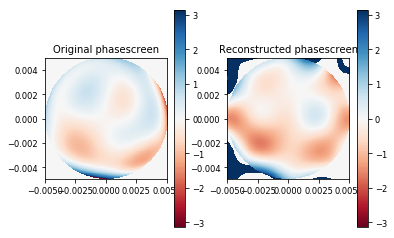

In [9]:
plt.clf()
plt.subplot(1,2,1)
imshow_field(wf2sense.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title("Original phasescreen")
plt.colorbar()
plt.subplot(1,2,2)
imshow_field(reconstructed_wf.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title("Reconstructed phasescreen")
plt.colorbar()

And let's take a look at the residual phase, i.e. the difference between the actual phase and the reconstructed phase.

/home/vikram/miniconda3/envs/hcipy/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


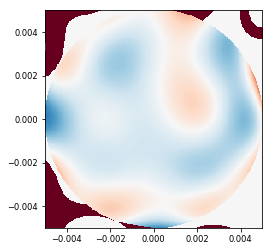

In [10]:
imshow_field(wf2sense.phase - reconstructed_wf.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu')

As can clearly be seen, the aberrations have markedly reduced, and the wavefront is much flatter than before! (Ignore the binary patterns outside the aperture - they are artefacts). If this procedure is run in closed loop, the wavefront can be flattened even further.